## Data:

In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# Load your dataset (adjust path)
file_path = "lfp_big.dat"
df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


#Assign columns (ignoring the last 2 extras if present)
columns = ["t", "se"] + \
          [f"qe{i}" for i in range(400)] + \
          ["si"]+\
          [f"qi{i}" for i in range(400)] + \
          ["ss"]+\
          [f"qs{i}" for i in range(400)] + \
          ["tt"]

df_lfp.columns = columns

/var/folders/h1/fq939csn2q9gqrlq02r8jqzw0000gn/T/ipykernel_68632/2433103981.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_lfp = pd.read_csv(file_path, delim_whitespace=True, header=None)


In [2]:
df_lfp.drop(columns="tt", inplace=True)

### Peaks of Lfp se

In [3]:
se_signal = df_lfp["se"].values
distance = 200
epsilon = 0.01
P = []  # Peaks
P_idx = []
T = []  # Troughs
T_idx = []

i = 0
n = len(se_signal)
searching_peak = True
peak = se_signal[i]

while i < n - distance:
    segment = se_signal[i:i+distance]

    if searching_peak:
        if np.max(segment) > peak+epsilon:
            j = np.argmax(segment)
            peak = np.max(segment)
            i = i+j
        else:
            P.append(peak)
            P_idx.append(i)
            peak = se_signal[i]
            searching_peak = False
            i+=1
    else:  # searching trough
        if np.min(segment) < peak-epsilon:
            j = np.argmin(segment)
            peak = np.min(segment)
            i+=j
        else:
            T.append(peak)
            T_idx.append(i)
            peak = se_signal[i]
            searching_peak = True
            i+=1

# Convert to NumPy arrays
P = np.array(P)
T = np.array(T)
P_idx = np.array(P_idx)

P_idx
tm = df_lfp['t'].values[P_idx]
tm

array([157.60001, 221.39999, 285.39999, 349.60001, 413.79999, 477.60001,
       541.59998, 606.     ])

In [4]:
# Find corresponding times for peak values using df_lfp
P_time_via_df = df_lfp.loc[df_lfp["se"].isin(P), "t"].values

# If you want to pair them with the values
peak_time_pairs = list(zip(P_time_via_df, P))

print(peak_time_pairs[:10])  # Show first 10 pairs
P_time_via_df
tm = P_time_via_df

[(157.60001, 1.6654304), (221.39999, 1.5491267), (285.39999, 1.4512016), (349.60001, 1.4659612), (413.79999, 1.4239748), (477.60001, 1.4591935), (541.59998, 1.4019922), (606.0, 1.5018433)]


### Peaks of Neurons

278     205.60001
521     254.20000
739     297.79999
1006    351.20001
1300    410.00000
1601    470.20001
1899    529.79999
2172    584.40002
2383    626.59998
Name: t, dtype: float64
[270.8464798891786, 184.50005624999991, 69.5326886191, 8.97196541182736, 338.69163822169423, 318.24452719607314, 293.6250251367306, 239.25480768484263]
Spike phases (degrees): [270.84647989 184.50005625  69.53268862   8.97196541 338.69163822
 318.2445272  293.62502514 239.25480768]
0.42357755234831695
-55.43599927151341


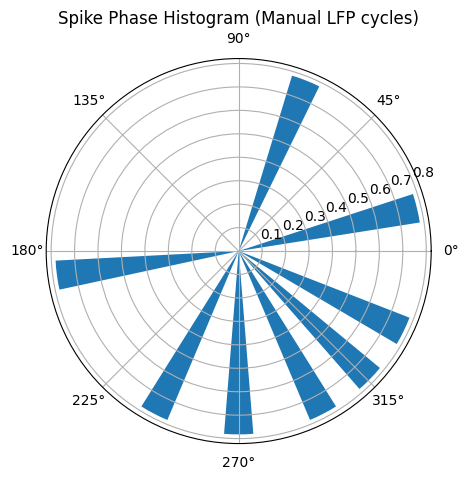

In [ ]:
from scipy.signal import find_peaks

peaks, _ = find_peaks(df_lfp.qe75, distance=distance)
t_peak = df_lfp.t[peaks]
print(t_peak)
# 2. Compute phase for each spike relative to LFP cycle
spike_phases = []
for x in t_peak:
    for k in range(len(tm)-1):
        lo = tm[k]
        hi = tm[k + 1]
        if lo < x < hi:
            period = hi - lo
            phase = 360 * (x - lo) / period
            spike_phases.append(phase)
            break

print(spike_phases)
# 3. Output or plot
spike_phases = np.array(spike_phases)
print("Spike phases (degrees):", spike_phases)

if len(spike_phases)>0:
    complex_phase = np.exp(1j*np.radians(spike_phases))
    vec = np.mean(complex_phase)
    MVL = np.abs(vec)
    preferred_phase = np.degrees(np.angle(vec))

print(MVL)
print(preferred_phase)

# Optional: Polar histogram
plt.figure(figsize=(5, 5))
plt.subplot(111, polar=True)
plt.hist(np.radians(spike_phases), bins=36, density=True)
plt.title("Spike Phase Histogram (Manual LFP cycles)")
plt.show()

### Evaluating MVL

In [6]:
from scipy.signal import find_peaks

# --- Parameters ---
num_neurons = 400
population_prefixes = ['qe', 'qi', 'qs']
mvl_results = {}

# --- Loop through all populations and neurons ---
for pop in population_prefixes:
    mvls = []
    for i in range(num_neurons):
        signal = df_lfp[f"{pop}{i}"].values
        peaks, _ = find_peaks(signal, distance=distance)
        if len(peaks) == 0:
            continue
        t_peaks = df_lfp['t'].values[peaks]

        # Compute phase of each spike w.r.t. se-cycle from tm
        spike_phases = []
        for x in t_peaks:
            for k in range(len(tm) - 1):
                lo = tm[k]
                hi = tm[k + 1]
                if lo < x < hi:
                    period = hi - lo
                    phase = 360 * (x - lo) / period
                    spike_phases.append(phase)
                    break

        if len(spike_phases) == 0:
            continue

        complex_phase = np.exp(1j * np.radians(spike_phases))
        vec = np.mean(complex_phase)
        mvl = np.abs(vec)
        mvls.append(mvl)

    # Store results for this population
    mvls = np.array(mvls)
    mvl_results[pop] = {
        'individual_mvls': mvls,
        'mean_mvl': np.mean(mvls) if len(mvls) > 0 else None,
        'n_neurons_used': len(mvls)
    }

# --- Display summary ---
for pop in population_prefixes:
    mean_mvl = mvl_results[pop]['mean_mvl']
    n = mvl_results[pop]['n_neurons_used']
    print(f"{pop}: Average MVL = {mean_mvl:.4f} across {n} neurons")

qe: Average MVL = 0.7997 across 400 neurons
qi: Average MVL = 0.9783 across 400 neurons
qs: Average MVL = 0.9858 across 400 neurons


### Creating custom functions:

In [ ]:
# Function to compute spike times via custom threshold crossing (>3 to <0)
def get_spike_times(signal, time_vector):
    spike_indices = []
    for j in range(len(signal) - 1):
        if signal[j] > 3 and signal[j + 1] < 0:
            spike_indices.append(j)  # mimic MATLAB's j-1 behavior
    return time_vector[spike_indices]

# Function to compute phase of each spike relative to LFP cycle
def compute_spike_phases(spike_times, tm):
    spike_phases = []
    for x in spike_times:
        for k in range(len(tm) - 1):
            lo = tm[k]
            hi = tm[k + 1]
            if lo < x < hi:
                period = hi - lo
                phase = 360 * (x - lo) / period
                spike_phases.append(phase)
                break
    return np.array(spike_phases)

# Function to compute MVL and preferred phase
def compute_mvl(phases_deg):
    if len(phases_deg) == 0:
        return None, None
    complex_phase = np.exp(1j * np.radians(phases_deg))
    vec = np.mean(complex_phase)
    mvl = np.abs(vec)
    preferred_phase = np.degrees(np.angle(vec))
    return mvl, preferred_phase

# Lists to store results
results = {"qe": [], "qi": [], "qs": []}

# Process each population group
for group in ["qe", "qi", "qs"]:
    for i in range(400):  # 400 neurons
        col = f"{group}{i}"
        if col not in df_lfp.columns:
            continue
        signal = df_lfp[col].values
        time_vector = df_lfp["t"].values
        spike_times = get_spike_times(signal, time_vector)
        phases = compute_spike_phases(spike_times, tm)
        mvl, preferred = compute_mvl(phases)
        results[group].append(mvl)

# Convert to DataFrame for easier viewing
df_mvl = pd.DataFrame({
    "qe_mvl": results["qe"],
    "qi_mvl": results["qi"],
    "qs_mvl": results["qs"]
})

# Compute average MVL per population
avg_mvl_qe = np.nanmean(df_mvl["qe_mvl"])
avg_mvl_qi = np.nanmean(df_mvl["qi_mvl"])
avg_mvl_qs = np.nanmean(df_mvl["qs_mvl"])

print("Average MVL:")
print(f"qe: {avg_mvl_qe:.3f}")
print(f"qi: {avg_mvl_qi:.3f}")
print(f"qs: {avg_mvl_qs:.3f}")

Average MVL:
qe: 0.781
qi: 0.969
qs: 0.979


In [10]:
df_lfp.tail()

,t,se,qe0,qe1,qe2,qe3,qe4,qe5,qe6,qe7,...,qs390,qs391,qs392,qs393,qs394,qs395,qs396,qs397,qs398,qs399
2496,649.20001,0.071365,1.900512,-0.570696,1.735940,1.393074,2.255448,0.798248,0.821831,0.741498,...,-1.868311,-2.021068,-1.879865,-1.803719,-1.837794,-1.831902,-1.861535,-1.974838,-1.951829,-1.752846
2497,649.40002,0.089009,1.922657,-0.571760,1.757922,1.415664,2.282633,0.822985,0.844356,0.763853,...,-1.868044,-2.020812,-1.879600,-1.803446,-1.837524,-1.831631,-1.861267,-1.974585,-1.951573,-1.752571
2498,649.59998,0.080457,1.944868,-0.572443,1.780017,1.438438,2.309476,0.848010,0.867193,0.786536,...,-1.867095,-2.020018,-1.878663,-1.802427,-1.836541,-1.830642,-1.860311,-1.973751,-1.950715,-1.751498
2499,649.79999,0.097726,1.966946,-0.573306,1.801977,1.461046,2.335889,0.872815,0.889837,0.809024,...,-1.866679,-2.019657,-1.878252,-1.801985,-1.836112,-1.830211,-1.859892,-1.973380,-1.950334,-1.751037
2500,650.00000,0.088337,1.989118,-0.573675,1.824086,1.483895,2.361999,0.898000,0.912885,0.831937,...,-1.865306,-2.018541,-1.876899,-1.800498,-1.834685,-1.828774,-1.858507,-1.972193,-1.949108,-1.749461
